### Introduction

This notebook is an experiment of building a model that will predict if a rookie player will last at least 5 years in the league based on his stats.

In the National Basketball Association (NBA), a rookie is any player who has never played a game in the NBA until that year. At the end of the season the NBA awards the best rookie with the NBA Rookie of the Year Award.

Moving to the NBA league is a big deal for any basketball player. Sport commentators and fans are very excited to follow the start of their careers and guess how they will perform in the future.

In this experiment, LogisticRegression model is used.

Data Preparation: 
1. Select the features which are highly correlated.
2. Scale all the selected features by Standard Scaler
3. Split the data into Train-Validation set
5. Resample the data using SMOTE over-sampling technique in each Train and Validation sets separately.

### Import the libraries

In [4]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import os
import sys
sys.path.append(os.path.abspath('..'))
from src.common_lib import DataReader, NBARawData
from src.models.aj_metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, plot_roc_curve
import matplotlib.pyplot as plt
from joblib import dump

from collections import Counter

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the data

In [5]:
# Instantiate the custom data reader class
data_reader = DataReader()

# Load Raw Train Data
train_df = data_reader.read_data(NBARawData.TRAIN)

# Load Test Raw Data
test_df = data_reader.read_data(NBARawData.TEST)

### Class Balance Check on Raw Data

Counter({1: 6669, 0: 1331})


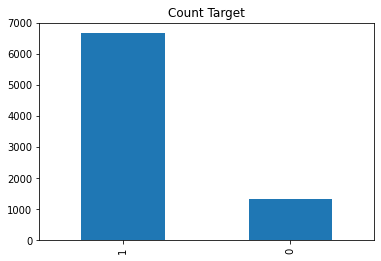

In [6]:
df_cleaned = train_df.copy()
target = df_cleaned.pop('TARGET_5Yrs')

print( Counter(target))
data_reader.plot_class_balance(target)

### Scaling with Standard Scaler

In [7]:
## Scaling
df_cleaned = train_df.copy()
target = df_cleaned.pop('TARGET_5Yrs')

train_df_scaled = data_reader.scale_features_by_standard_scaler(df_cleaned)
train_df_scaled

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,0.930059,-1.731834,1.006100,0.640574,0.123403,0.113959,0.047090,0.177269,-0.428374,-0.486911,...,0.655953,0.760387,0.070392,1.428377,-0.121037,0.266040,1.161949,1.107242,-0.055071,0.473210
1,-0.380914,-1.731401,0.714005,0.360766,0.748626,0.822648,0.465578,1.704465,-1.469853,-1.712288,...,1.087875,1.319370,-0.341888,3.210407,1.100107,1.608950,-0.681844,-0.364787,0.432148,0.196671
2,-0.286878,-1.730968,1.298195,0.058574,-0.640758,-0.535673,-0.482994,-0.293888,0.352736,0.361427,...,-1.071732,-1.076272,0.415557,-0.608229,-0.264701,-0.405415,-0.608092,-0.610125,-0.055071,-0.909485
3,1.743194,-1.730535,0.012976,0.058574,0.216029,0.409246,0.130788,1.282049,0.092366,-0.015612,...,-0.531830,-0.357579,-0.428180,-0.353653,-0.121037,-0.117649,0.129425,-0.610125,-0.176876,0.888019
4,-0.348731,-1.730102,0.012976,-0.086926,-0.826009,-0.653788,-0.789885,1.005854,0.613106,0.549947,...,-1.287692,-1.156127,-1.665021,1.682952,0.381787,0.793612,-0.903099,-0.610125,0.432148,-0.771215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,-0.970776,1.730102,-1.798014,-1.049465,-1.265980,-1.244362,-1.236272,-0.700057,-0.949113,-0.958210,...,-1.071732,-1.076272,-0.543235,-0.990093,-0.264701,-0.645220,-0.829347,-0.855464,-0.055071,-1.186024
7996,1.212418,1.730535,-0.512795,-1.407619,-1.265980,-1.244362,-1.347869,0.664672,-0.428374,-0.675430,...,-1.287692,-1.235982,-0.121366,-0.099078,-0.767525,-0.597259,-1.124354,-1.591478,0.066734,-1.324294
7997,-0.331885,1.730968,1.298195,1.077074,0.794939,0.704533,0.772469,0.079788,-0.168004,-0.204131,...,1.519796,1.558934,-0.159718,-0.099078,-0.049205,-0.069687,1.309452,1.352580,-0.055071,0.749749
7998,-1.399219,1.731401,-1.389081,-1.217350,-1.103885,-1.067190,-1.096776,-0.732551,-1.469853,-1.240989,...,-0.855771,-0.996417,0.281326,-0.862805,-1.126685,-1.124831,-1.050602,-0.855464,0.066734,-1.047755


### Select Features

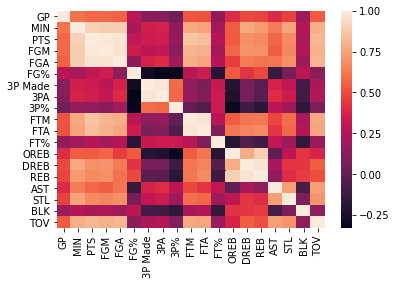

In [8]:
selected_features = data_reader.select_feature_by_correlation(df_cleaned, ['Id', 'Id_old'])

In [25]:
selected_features

Index(['GP', 'MIN', 'FG%', '3P Made', '3P%', 'FTM', 'FT%', 'OREB', 'DREB',
       'AST', 'STL', 'BLK', 'TOV', 'TARGET_5Yrs'],
      dtype='object')

### Split Train and Test on Scaled Data with Selected Features

In [15]:
train_df_scaled['TARGET_5Yrs'] = target 
X_train, X_val, y_train, y_val = data_reader.split_data(train_df_scaled)

Counter({1: 5326, 0: 1074})


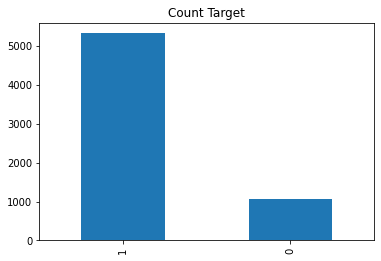

In [37]:
### Visualisation Before Sampling Classification Count
print( Counter(y_train))
data_reader.plot_class_balance(y_train)

Counter({1: 1343, 0: 257})


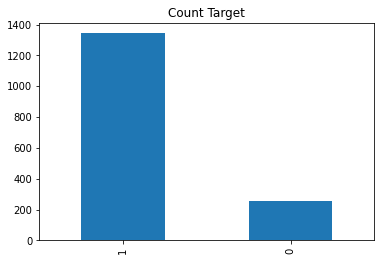

In [38]:
print(Counter(y_val))
data_reader.plot_class_balance(y_val)

### Re-sampling -  Over Sampling

array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

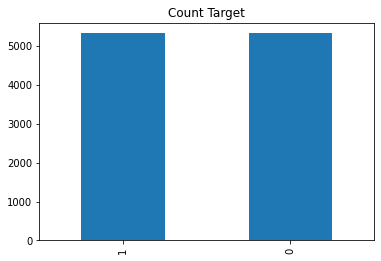

In [19]:
# Resample Train Data
X_train_res, y_train_res = data_reader.resample_data_upsample_smote(X_train, y_train)
X_val_res, y_val_res = data_reader.resample_data_upsample_smote(X_val, y_val)

# Re-plot the target
data_reader.plot_class_balance(y_train_res)

### Build The Model - Logistic Regression

In [14]:
log_reg = LogisticRegression().fit(X_train_res, y_train_res)

### Accuracy Test on Train Set

In [1]:
#y_train_prob = log_reg.predict_proba(X_train_res)[:,1]

## Check Accuracy Score
y_pred=log_reg.predict(X_train_res)

# Check Accuracy Score
print("accuracy_score:",accuracy_score(y_train_res, y_pred))
plot_roc_curve(log_reg, X_train_res, y_train_res)
confusion_matrix(y_train_res, y_pred)

NameError: name 'log_reg' is not defined

### Accuracy Check on Validation Set

accuracy_score 0.6485480268056589


,pred:0,pred:1
true:0,890,453
true:1,491,852


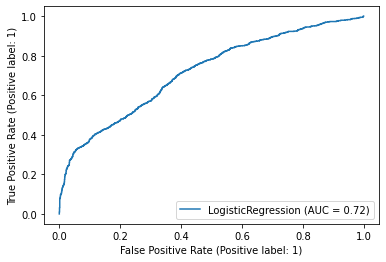

In [42]:
## Check Accuracy Score
y_pred=log_reg.predict(X_val_res)

# # Check Accuracy Score
print("accuracy_score", accuracy_score(y_val_res, y_pred))
plot_roc_curve(log_reg,X_val_res, y_val_res)
confusion_matrix(y_val_res, y_pred)
                 

### Model Prediction on Test Set for Submission

In [22]:
# Apply the same data preparation procedure done in Training Data to the Test data

# 1. Select the features
features_without_target = np.delete(selected_features, 13)
test_df_selected_features = test_df[features_without_target]

# 2 Scale the features
test_df_scaled =  data_reader.scale_features_by_standard_scaler(test_df_selected_features)


y_test_proba =log_reg.predict_proba(test_df_scaled)[:,1]


final_prediction_test = pd.DataFrame({'Id': range(0,3799), 'TARGET_5Yrs': [p for p in y_test_proba]})
final_prediction_test.to_csv("../reports/tin_submission_stdscale_smote_logistic_regression_selFeatures.csv", index=False)

final_prediction_test.head(10)

,Id,TARGET_5Yrs
0,0,0.477408
1,1,0.454545
2,2,0.732773
3,3,0.783287
4,4,0.412399
5,5,0.714216
6,6,0.333125
7,7,0.419366
8,8,0.559182
9,9,0.201586
